In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import re
%matplotlib inline
import json;
import os;
with open("./secrets/secrets.json") as json_file:  
            secrets = json.load(json_file);
os.environ["WEB3_INFURA_PROJECT_ID"] = secrets["WEB3_INFURA_PROJECT_ID"];
from web3.auto.infura import w3 as web3;

## Get addresses from etherscan

In [76]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3"}
reg_url = "https://etherscan.io/accounts/label/exchange/1?ps=100"
req = Request(url=reg_url, headers=headers) 
html = urlopen(req).read().decode('utf-8')

In [77]:
res1 = re.findall("address/0x.{40}", html)
res1 = re.findall("0x.{40}", str(res1))

In [78]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3"}
reg_url = "https://etherscan.io/accounts/label/exchange/2?ps=100"
req = Request(url=reg_url, headers=headers) 
html = urlopen(req).read().decode('utf-8')

In [79]:
res2 = re.findall("address/0x.{40}", html)
res2 = re.findall("0x.{40}", str(res2))

In [80]:
set1 = set().union(res1, res2)
set1.discard("0x71c7656ec7ab88b098defb751b7401b5f6d8976f") # donation address
exchangeAddresses = [web3.toChecksumAddress(addr) for addr in set1] # format 
    
print("{} addresses scraped from Etherscan.".format(len(exchangeAddresses)))

186 addresses scraped from Etherscan.


## Save addresses locally

In [81]:
import json
with open('exchangeAccounts.json', 'w') as json_file:
    json.dump(exchangeAddresses, json_file)

## Get balances for each address

In [82]:
balances_list = [web3.eth.getBalance(addr) for addr in exchangeAddresses]

In [83]:
balances = pd.DataFrame(zip(exchangeAddresses, balances_list), columns=["address", "balance"])
balances["balance"] = pd.to_numeric(balances["balance"])

In [84]:
address, balance = balances.loc[balances["balance"].idxmax()]
display(balances.describe())
print("The address {address} has the highest balance: {balance}.".format(address = address, balance = balance))

,balance
count,1.860000e+02
mean,5.501953e+22
std,2.808606e+23
min,0.000000e+00
25%,2.449790e+18
50%,5.764922e+19
75%,1.574980e+21
max,2.201523e+24


The address 0xBE0eB53F46cd790Cd13851d5EFf43D12404d33E8 has the highest balance: 2.2015228557509146e+24.


In [85]:
balances_sorted = balances.sort_values(by="balance", ascending=False);
balances_sorted = balances_sorted.reset_index(drop=True);

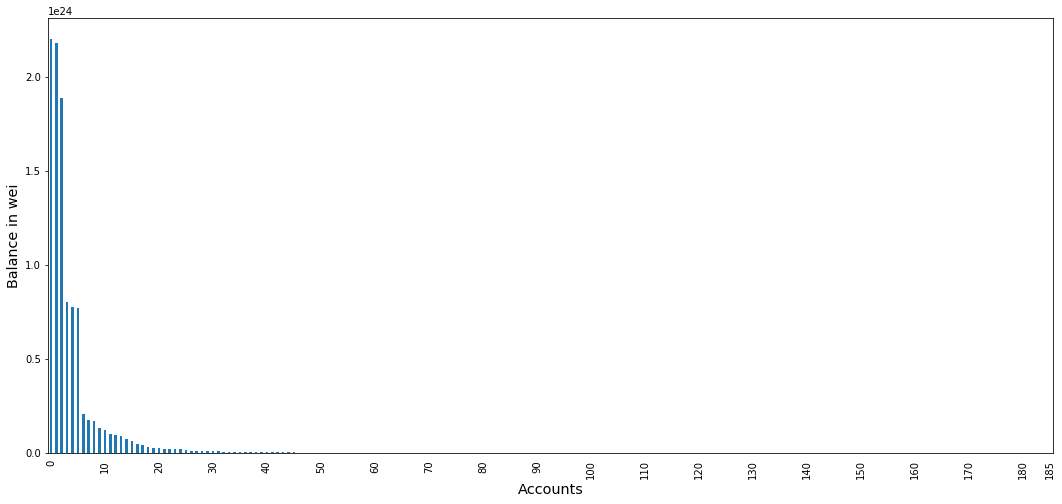

In [86]:
axes = balances_sorted.plot.bar(figsize=(18,8))

axes.tick_params(
    axis='x',          
    bottom=False,      
    top=False,         
    labelbottom=True)

axes.set_xlabel("Accounts", fontsize="x-large");
axes.set_ylabel("Balance in wei", fontsize="x-large");

legend = axes.get_legend();
legend.set_visible(False);


ticketlabels = axes.xaxis.get_ticklabels();
for index, ticklabel in enumerate(ticketlabels):
    if (index % 10 == 0 or index == len(ticketlabels) - 1) :
        ticklabel.set_visible(True)
    else:
        ticklabel.set_visible(False)

In [87]:
total_balance = balances_sorted.sum()["balance"];
sum_tmp = 0;
balances_compressed = [];
quantile = 0.8

for index, row in balances_sorted.iterrows():
    sum_tmp = sum_tmp + row["balance"]
    if (sum_tmp / total_balance > quantile):
        break;
    balances_compressed.append(row)
    
balances_compressed = pd.DataFrame(balances_compressed, columns=["address", "balance"])

print("The following {} accounts have more than {} % of the total balance.".format(len(balances_compressed), int(quantile * 100)))
display(balances_compressed)

The following 5 accounts have more than 80 % of the total balance.


,address,balance
0,0xBE0eB53F46cd790Cd13851d5EFf43D12404d33E8,2.201523e+24
1,0x742d35Cc6634C0532925a3b844Bc454e4438f44e,2.176401e+24
2,0xDc76CD25977E0a5Ae17155770273aD58648900D3,1.885861e+24
3,0xE853c56864A2ebe4576a807D26Fdc4A0adA51919,8.010528e+23
4,0x66f820a414680B5bcda5eECA5dea238543F42054,7.750006e+23


In [88]:
duration = int((30*24*60*60)/12); # one month
# duration = int((24*60*60)/12); # one day

latestBlockNumber = web3.eth.getBlock('latest').number;
time_in_blocks = range(0,latestBlockNumber,duration);

In [89]:
import time;
from datetime import datetime;

start = time.time();

balances = [];
sum_of_balances_tmp = [];
unixtimestamps = [];
addresses = balances_compressed["address"];

for block in time_in_blocks:
    b = [web3.eth.getBalance(web3.toChecksumAddress(addr), block_identifier=block) for addr in addresses];
    balances.append(tuple(b))
    sum_of_balances_tmp.append(sum(b));
    unixtimestamps.append(web3.eth.getBlock(block).timestamp);
    
# sum_of_balances = pd.DataFrame(zip(sum_of_balances_tmp, unixtimestamps), columns=["total_balance_in_wei","timestamp_unix"]);

end = time.time();

print("Time elapsed: {seconds}".format(seconds=end-start));

Time elapsed: 33.93614435195923


In [90]:
sum_of_balances = pd.DataFrame(list(zip(*balances))).transpose();
sum_of_balances.columns = [c for c in addresses];
sum_of_balances["timestamp_unix"] = unixtimestamps;
sum_of_balances["total_balance_in_wei"] = sum_of_balances_tmp;
for colName in sum_of_balances:
    if (colName != "timestamp_unix"):
        print(colName)
        sum_of_balances.loc[: , colName] = sum_of_balances.loc[: , colName].astype("float")
sum_of_balances

0xBE0eB53F46cd790Cd13851d5EFf43D12404d33E8
0x742d35Cc6634C0532925a3b844Bc454e4438f44e
0xDc76CD25977E0a5Ae17155770273aD58648900D3
0xE853c56864A2ebe4576a807D26Fdc4A0adA51919
0x66f820a414680B5bcda5eECA5dea238543F42054
total_balance_in_wei


,0xBE0eB53F46cd790Cd13851d5EFf43D12404d33E8,0x742d35Cc6634C0532925a3b844Bc454e4438f44e,0xDc76CD25977E0a5Ae17155770273aD58648900D3,0xE853c56864A2ebe4576a807D26Fdc4A0adA51919,0x66f820a414680B5bcda5eECA5dea238543F42054,timestamp_unix,total_balance_in_wei
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1441938565,0.000000e+00
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1445682932,0.000000e+00
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1449372180,0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1453066054,0.000000e+00
5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1456783758,0.000000e+00
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1460075883,0.000000e+00
7,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1463174778,0.000000e+00
8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1466275351,0.000000e+00
9,0.000000e+00,0.000000e+00,0.000000e+00,7.791350e+24,0.000000e+00,1469365781,7.791350e+24


In [91]:
sum_of_balances.loc[: , "timestamp_unix"] = [datetime.utcfromtimestamp(ts).strftime('%Y-%m') for ts in sum_of_balances.loc[:,"timestamp_unix"]]
sum_of_balances = sum_of_balances.drop(index=0)

Text(0, 0, '2015-09')

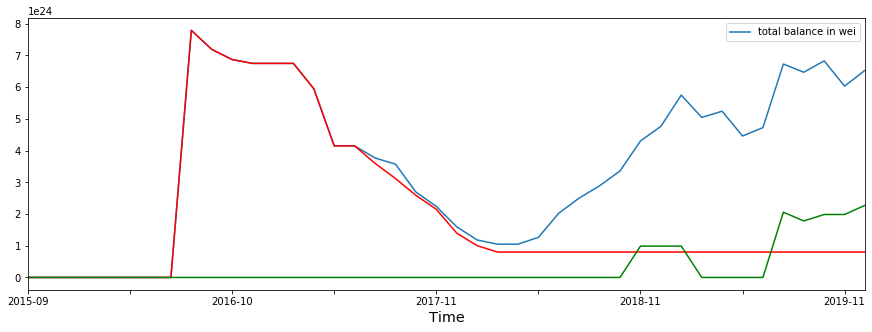

In [92]:
ax = sum_of_balances.plot(x="timestamp_unix", y="total_balance_in_wei", figsize=(15,5))
ax = sum_of_balances.plot(x="timestamp_unix", y="0xE853c56864A2ebe4576a807D26Fdc4A0adA51919", color="red", ax=ax)
ax = sum_of_balances.plot(x="timestamp_unix", y="0xBE0eB53F46cd790Cd13851d5EFf43D12404d33E8", color="green", ax=ax)

# fig, ax = plt.subplot(figsize=(15,5))


ax.tick_params(
    axis='x', 
    bottom=True,      
    top=False,        
    labelbottom=True) 

ax.legend(['total balance in wei'])

ax.set_xlabel("Time", fontsize="x-large");
# ax.set_ylabel("total balance in wei", fontsize="x-large");

ticketlabels = ax.xaxis.get_ticklabels()
display(ticketlabels[0]) 

for index, ticklabel in enumerate(ticketlabels):
    if (index % 2 == 0 or index == len(ticketlabels) - 1) :
        ticklabel.set_visible(True)
    else:
        ticklabel.set_visible(False)

In [93]:
sum_of_balances = sum_of_balances[sum_of_balances["total_balance_in_wei"] > 0]

In [94]:
sum_of_balances

,0xBE0eB53F46cd790Cd13851d5EFf43D12404d33E8,0x742d35Cc6634C0532925a3b844Bc454e4438f44e,0xDc76CD25977E0a5Ae17155770273aD58648900D3,0xE853c56864A2ebe4576a807D26Fdc4A0adA51919,0x66f820a414680B5bcda5eECA5dea238543F42054,timestamp_unix,total_balance_in_wei
9,0.000000e+00,0.000000e+00,0.000000e+00,7.791350e+24,0.000000e+00,2016-07,7.791350e+24
10,0.000000e+00,0.000000e+00,0.000000e+00,7.191340e+24,0.000000e+00,2016-08,7.191340e+24
11,0.000000e+00,0.000000e+00,0.000000e+00,6.869628e+24,0.000000e+00,2016-10,6.869628e+24
12,0.000000e+00,0.000000e+00,0.000000e+00,6.749428e+24,0.000000e+00,2016-11,6.749428e+24
13,0.000000e+00,0.000000e+00,0.000000e+00,6.749428e+24,0.000000e+00,2016-12,6.749428e+24
14,0.000000e+00,0.000000e+00,0.000000e+00,6.749428e+24,0.000000e+00,2017-01,6.749428e+24
15,0.000000e+00,0.000000e+00,0.000000e+00,5.949328e+24,0.000000e+00,2017-02,5.949328e+24
16,0.000000e+00,0.000000e+00,0.000000e+00,4.149228e+24,0.000000e+00,2017-04,4.149228e+24
17,0.000000e+00,0.000000e+00,0.000000e+00,4.148902e+24,0.000000e+00,2017-05,4.148902e+24
18,0.000000e+00,0.000000e+00,1.679543e+23,3.598902e+24,0.000000e+00,2017-06,3.766857e+24


In [95]:
sum_of_balances = sum_of_balances.reset_index(drop=True);

In [96]:
sum_of_balances

,0xBE0eB53F46cd790Cd13851d5EFf43D12404d33E8,0x742d35Cc6634C0532925a3b844Bc454e4438f44e,0xDc76CD25977E0a5Ae17155770273aD58648900D3,0xE853c56864A2ebe4576a807D26Fdc4A0adA51919,0x66f820a414680B5bcda5eECA5dea238543F42054,timestamp_unix,total_balance_in_wei
0,0.000000e+00,0.000000e+00,0.000000e+00,7.791350e+24,0.000000e+00,2016-07,7.791350e+24
1,0.000000e+00,0.000000e+00,0.000000e+00,7.191340e+24,0.000000e+00,2016-08,7.191340e+24
2,0.000000e+00,0.000000e+00,0.000000e+00,6.869628e+24,0.000000e+00,2016-10,6.869628e+24
3,0.000000e+00,0.000000e+00,0.000000e+00,6.749428e+24,0.000000e+00,2016-11,6.749428e+24
4,0.000000e+00,0.000000e+00,0.000000e+00,6.749428e+24,0.000000e+00,2016-12,6.749428e+24
5,0.000000e+00,0.000000e+00,0.000000e+00,6.749428e+24,0.000000e+00,2017-01,6.749428e+24
6,0.000000e+00,0.000000e+00,0.000000e+00,5.949328e+24,0.000000e+00,2017-02,5.949328e+24
7,0.000000e+00,0.000000e+00,0.000000e+00,4.149228e+24,0.000000e+00,2017-04,4.149228e+24
8,0.000000e+00,0.000000e+00,0.000000e+00,4.148902e+24,0.000000e+00,2017-05,4.148902e+24
9,0.000000e+00,0.000000e+00,1.679543e+23,3.598902e+24,0.000000e+00,2017-06,3.766857e+24


([<matplotlib.axis.XTick at 0x7f81bb999940>,
 <a list of 17 Text xticklabel objects>)

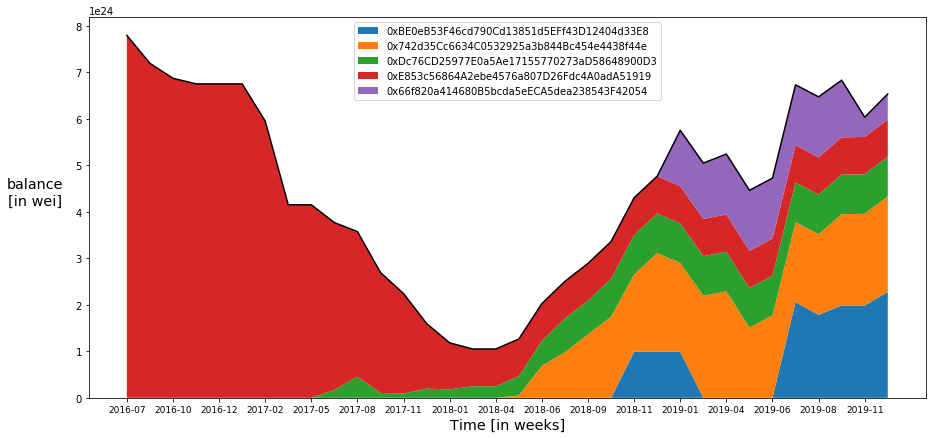

In [147]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["0xBE0eB53F46cd790Cd13851d5EFf43D12404d33E8","0x742d35Cc6634C0532925a3b844Bc454e4438f44e","0xDc76CD25977E0a5Ae17155770273aD58648900D3","0xE853c56864A2ebe4576a807D26Fdc4A0adA51919","0x66f820a414680B5bcda5eECA5dea238543F42054"]

fig, ax = plt.subplots(figsize= (15,7))
ax.stackplot(sum_of_balances["timestamp_unix"], sum_of_balances.iloc[:,0], sum_of_balances.iloc[:,1], sum_of_balances.iloc[:,2], sum_of_balances.iloc[:,3], sum_of_balances.iloc[:,4], labels=labels)
# ax.stackplot(x=list(sum_of_balances["timestamp_unix"]), labels=labels)
ax.legend(loc='upper center')

plt.plot(sum_of_balances["timestamp_unix"], sum_of_balances["total_balance_in_wei"],color="black")

ax.tick_params(
    axis='x', 
    bottom=True,      
    top=False,        
    labelbottom=True,
    labelsize=9
    ) 

# ax.legend(['total balance in wei', "jo"])

ax.set_xlabel("Time [in weeks]", fontsize="x-large");
h = ax.set_ylabel("balance\n[in wei]", fontsize="x-large", rotation=0, labelpad=40);

# ticketlabels = ax.xaxis.get_ticklabels()
# majorTicks = ax.xaxis.get_major_ticks()

# for index, ticklabel in enumerate(ticketlabels):
#     if (index % 2 == 0):
#         ticklabel.set_visible(True)
#         majorTicks[index].set_visible(True)
#     else:
#         ticklabel.set_visible(False)        
#         majorTicks[index].set_visible(False)
        
locs, labels = plt.xticks()
# display(locs)
# display(labels)
plt.xticks(range(0,len(locs),2))

In [71]:
sum_of_balances["timestamp_unix"]

0     1469365781
1     1472456768
2     1475546922
3     1478647999
4     1481736950
5     1484817668
6     1487909844
7     1491026615
8     1494252942
9     1497711748
10    1501594855
11    1506630908
12    1510453148
13    1513566553
14    1516854232
15    1520008093
16    1523144644
17    1526359214
18    1529637326
19    1532821153
20    1535972496
21    1539049430
22    1542099992
23    1545179793
24    1548487485
25    1552254679
26    1555163830
27    1558072824
28    1560991574
29    1563899459
30    1566797497
31    1569709939
32    1572656943
33    1575812057
Name: timestamp_unix, dtype: int64

11


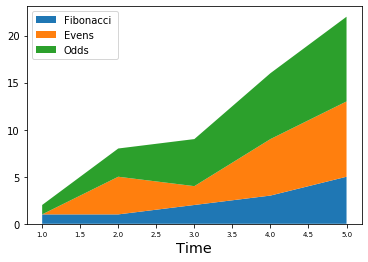

In [74]:
import numpy as np
import matplotlib.pyplot as plt

x = [1, 2, 3, 4, 5]
y1 = [1, 1, 2, 3, 5]
y2 = [0, 4, 2, 6, 8]
y3 = [1, 3, 5, 7, 9]

y = np.vstack([y1, y2, y3])

labels = ["Fibonacci ", "Evens", "Odds"]

fig, ax = plt.subplots()
ax.stackplot(x, y1, y2, y3, labels=labels)
ax.legend(loc='upper left')

ax.tick_params(
    axis='x', 
    bottom=True,      
    top=False,        
    labelbottom=True,
    labelsize=7
) 

# ax.legend(['total balance in wei', "jo"])

ax.set_xlabel("Time", fontsize="x-large");
# ax.set_ylabel("total balance in wei", fontsize="x-large");

ticketlabels = ax.xaxis.get_ticklabels()
# majorTicks = ax.xaxis.get_major_ticks()
print(len(ticketlabels))

# for index, ticklabel in enumerate(ticketlabels):
#     if (index % 2 == 0 or index == len(ticketlabels) - 1) :
#         ticklabel.set_visible(True)
#         ticketlabels[index] = "test"
#         majorTicks[index].set_visible(True)
#     else:
#         ticklabel.set_visible(False)        
#         majorTicks[index].set_visible(False)


# Deprecated

In [27]:
def isNoContract(address= "0xfa52274dd61e1643d2205169732f29114bc240b3"):
    res = web3.eth.getCode(web3.toChecksumAddress(address));
    return not bool(res)

In [32]:
# sum_of_balances_stringified = json.dumps(sum_of_balances);
sum_of_balances_stringified = sum_of_balances.to_json()

with open('./sum_of_balances_from_etherscan_exchange_accounts.json', 'w') as f:
    print(sum_of_balances_stringified, file=f);